In [221]:
import gymnasium
import flappy_bird_gymnasium
import numpy as np
import pygame
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from enum import IntEnum
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
from flappy_bird_gymnasium.envs.flappy_bird_env import Actions
from flappy_bird_gymnasium.envs.lidar import LIDAR
from flappy_bird_gymnasium.envs.constants import (
    PLAYER_FLAP_ACC,
    PLAYER_ACC_Y,
    PLAYER_MAX_VEL_Y,
    PLAYER_HEIGHT,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
    PIPE_WIDTH,
    PIPE_VEL_X,
)

def new_render(self):
    """Renders the next frame."""
    if self.render_mode == "rgb_array":
        self._draw_surface(show_score=False, show_rays=False)
        # Flip the image to retrieve a correct aspect
        return np.transpose(pygame.surfarray.array3d(self._surface), axes=(1, 0, 2))
    else:
        self._draw_surface(show_score=True, show_rays=False)
        if self._display is None:
            self._make_display()

        self._update_display()
        self._fps_clock.tick(self.metadata["render_fps"])


FlappyBirdEnv.render = new_render

In [229]:
###############
######DQN######
###############

class DQN(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)   
        self.fc3 = nn.Linear(128, 128)      # Second hidden layer
        self.fc4 = nn.Linear(128, action_space)  # Output layer for Q-values

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)



# Replay Memory to store experiences
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# DQN Agent Class
class DQNAgent:
    def __init__(self, 
                 env,
                 hyper ={
                          "learning_rate": 0.001,
                          "discount_factor" : 0.99,
                          "epsilon" : 1.0,
                          "epsilon_decay" :0.999,
                          "epsilon_min" : 0.01,
                          "batch_size" : 64,
                          "memory_size" : 10000,
                          "episodes" : 100000,
                          "target_update_freq" : 10
                        }
                 ):
        # Environment
        self.env = env
        self.state_dim = env.observation_space.shape[0]  # First dimension of observation
        self.action_space = env.action_space.n


        # Hyperparameters
        self.learning_rate = hyper["learning_rate"]
        self.discount_factor = hyper["discount_factor"]
        self.epsilon = hyper["epsilon"]
        self.epsilon_decay = hyper["epsilon_decay"]
        self.epsilon_min = hyper["epsilon_min"]
        self.batch_size = hyper["batch_size"]
        self.memory_size = hyper["memory_size"]
        self.episodes = hyper["episodes"]
        self.target_update_freq = hyper["target_update_freq"]

        # Initialize policy and target networks
        self.policy_net = DQN(self.state_dim, self.action_space)
        self.target_net = DQN(self.state_dim, self.action_space)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

    def select_action(self, state, testing=False):
        """Epsilon-greedy action selection."""
        if not testing and random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Random action
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).argmax(dim=1).item()

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        res=[]
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Optimize model
                self.optimize_model()

            # Update target network periodically
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10,render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state, testing=True)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        return total_rewards

In [223]:
#############################
######AC policygradient######
#############################


class ActorCriticNet(nn.Module):
    def __init__(self, input_dim, action_space):
        super(ActorCriticNet, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        
        # Actor head
        self.actor = nn.Linear(128, action_space)
        
        # Critic head
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        policy_logits = torch.softmax(self.actor(x), dim=-1)  # Action probabilities
        value = self.critic(x)  # State value
        return policy_logits, value
    
class ActorCriticAgent:
    def __init__(self, env):
        # Environment
        self.env = env
        self.state_dim = env.observation_space.shape[0]  # First dimension of observation
        self.action_space = env.action_space.n

        # Hyperparameters
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.episodes = 5000

        # Initialize actor-critic network
        self.actor_critic_net = ActorCriticNet(self.state_dim, self.action_space)
        self.optimizer = optim.Adam(self.actor_critic_net.parameters(), lr=self.learning_rate)

        # Memory for rewards, values, and log probabilities
        self.log_probs = []
        self.rewards = []
        self.values = []

    def select_action(self, state):
        """Select an action based on the policy."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        policy_logits, value = self.actor_critic_net(state)
        action_dist = torch.distributions.Categorical(policy_logits)
        action = action_dist.sample()
        
        # Store log probability and value
        self.log_probs.append(action_dist.log_prob(action))
        self.values.append(value)
        return action.item()

    def compute_returns(self):
        """Compute discounted returns for each time step."""
        returns = []
        G = 0
        for reward in reversed(self.rewards):
            G = reward + self.discount_factor * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        return returns

    def train_step(self):
        """Perform a training step after one episode."""
        returns = self.compute_returns()
        values = torch.cat(self.values).squeeze()
        log_probs = torch.cat(self.log_probs)
        
        # Compute advantage
        advantage = returns - values.detach()  # Detach critic from the actor's gradient computation
        
        # Actor loss (policy gradient with advantage)
        actor_loss = -(log_probs * advantage).mean()

        # Critic loss (value estimation error)
        critic_loss = torch.nn.functional.mse_loss(values, returns)

        # Total loss
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear memory
        self.log_probs = []
        self.rewards = []
        self.values = []

    def train(self):
        res = []
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                
                self.rewards.append(reward)
                state = next_state
                total_reward += reward

            # Perform a training step after the episode ends
            self.train_step()

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

        self.env.close()
        print("Training complete!")
        return res

    def test(self, num_episodes=10, render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render, use_lidar=True)
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0

            while not done:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                policy_logits, _ = self.actor_critic_net(state)
                action = torch.argmax(policy_logits).item()  # Select action with highest probability
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()

        return total_rewards

In [ ]:
#############################
######Policygradient#########
#############################

class PolicyGradientNet(nn.Module):
    def __init__(self, input_dim, action_space):
        super(PolicyGradientNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)       # Second hidden layer
        self.fc3 = nn.Linear(128, action_space)  # Output layer for action probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)  # Apply softmax to output layer for probabilities


# Policy Gradient Agent Class
class PolicyGradientAgent:
    def __init__(self, env):
        # Environment
        self.env = env
        self.state_dim = env.observation_space.shape[0]  # First dimension of observation
        self.action_space = env.action_space.n

        # Hyperparameters
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.episodes = 2000

        # Initialize policy network
        self.policy_net = PolicyGradientNet(self.state_dim, self.action_space)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Memory for rewards and log probabilities
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        """Select an action based on policy."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        self.log_probs.append(action_dist.log_prob(action))
        return action.item()

    def compute_returns(self):
        """Compute discounted returns for each time step."""
        returns = []
        G = 0
        for reward in reversed(self.rewards):
            G = reward + self.discount_factor * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        # Normalize returns for better convergence
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def train_step(self):
        """Perform a training step after one episode."""
        returns = self.compute_returns()
        loss = 0
        for log_prob, G in zip(self.log_probs, returns):
            loss += -log_prob * G  # Negative sign for gradient ascent

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear memory
        self.log_probs = []
        self.rewards = []

    def train(self):
        res=[]
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.rewards.append(reward)
                state = next_state
                total_reward += reward

            # Perform a training step after the episode ends
            self.train_step()

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

        self.env.close()
        print("Training complete!")
        return res

    def test(self, num_episodes=10,render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render, use_lidar=True)
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0

            while not done:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                probs = self.policy_net(state)
                action = torch.argmax(probs).item()  # Select action with highest probability
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()




In [ ]:
#####################
######DQNCNN#########
#####################

class DQNCNN(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DQNCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_dim[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._calculate_conv_output(input_dim), 512)
        self.fc2 = nn.Linear(512, action_space)

    def _calculate_conv_output(self, input_dim):
        dummy_input = torch.zeros(1, *input_dim)
        x = self.conv1(dummy_input)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(torch.prod(torch.tensor(x.shape[1:])))
    
    def forward(self, x):
        x = x.view(x.size(0), -1, x.size(-2), x.size(-1))
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQCNNAgent:
    def __init__(self, env, input_dim, action_space):
        self.env = env
        self.input_dim = input_dim
        self.action_space = action_space

        # Hyperparameters
        self.learning_rate = 0.0001
        self.discount_factor = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.batch_size = 64
        self.memory_size = 10000
        self.target_update_freq = 10

        # Networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQNCNN(input_dim, action_space).to(self.device)
        self.target_net = DQNCNN(input_dim, action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

        # Preprocessing pipeline
        self.preprocess = Compose([ToTensor(), Resize((84, 84)), Grayscale()])

    def preprocess_frame(self, frame):
        return self.preprocess(frame).numpy()

    def select_action(self, state, testing=False):
        if not testing and np.random.rand() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Q-value computation
        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + (1 - dones) * self.discount_factor * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes=1000):
        results = []
        for episode in range(episodes):
            state, _ = self.env.reset()
            frame = self.env.render()  # Query the initial rendered frame
            state = self.preprocess_frame(frame)
            state_stack = np.stack([state] * 4, axis=0)
            total_reward = 0
            done = False

            while not done:
                action = self.select_action(state_stack)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_frame = self.env.render()  # Query the next rendered frame
                next_state = self.preprocess_frame(next_frame)
                next_state_stack = np.append(state_stack[1:], [next_state], axis=0)

                self.memory.push(state_stack, action, reward, next_state_stack, done)
                self.optimize_model()
                state_stack = next_state_stack
                total_reward += reward

                if truncated:
                    done = True

            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            results.append(total_reward)
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")
        return results


    def test(self, num_episodes=10):
        self.epsilon = 0.0  # Test with deterministic policy
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            frame = self.env.render()  # Query the rendered frame
            state = self.preprocess_frame(frame)
            state_stack = np.stack([state] * 4, axis=0)
            total_reward = 0
            done = False

            while not done:
                action = self.select_action(state_stack, testing=True)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_frame = self.env.render()  # Query the rendered frame
                state_stack = np.append(state_stack[1:], [self.preprocess_frame(next_frame)], axis=0)
                total_reward += reward

                if truncated:
                    done = True

            total_rewards.append(total_reward)
            print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")




In [160]:
################
######DQN+######
################

class DQN_plus(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DQN_plus, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)   
        self.fc3 = nn.Linear(128, 128)      # Second hidden layer
        self.fc4 = nn.Linear(128, action_space)  # Output layer for Q-values

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)



# Replay Memory to store experiences
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# DQN Agent Class
class DQN_plus_Agent:
    def __init__(self, env):
        # Environment
        self.env = env
        self.state_dim = env.observation_space.shape[0]  
        self.action_space = env.action_space.n

        # Hyperparameters
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.epsilon = 1.0  
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.memory_size = 10000
        self.episodes = 100000
        self.target_update_freq = 10
        self.theta = 1.0

        # Initialize policy and target networks
        self.policy_net = DQN(self.state_dim, self.action_space)
        self.target_net = DQN(self.state_dim, self.action_space)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

    def select_action(self, state, testing=False):
        """Epsilon-greedy action selection."""
        if not testing and random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Random action
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).argmax(dim=1).item()

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        res=[]
        reward_trace=0
        old_reward_trace=0
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Optimize model
                self.optimize_model()

            # Update target network periodically
            reward_trace+=total_reward
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

                
                if (reward_trace-old_reward_trace)/self.target_update_freq <self.theta and self.epsilon<self.epsilon_min*2 :
                    self.epsilon=0.5
                    
                old_reward_trace=reward_trace
                reward_trace=0

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10,render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state, testing=True)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()

In [230]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)
exp_res = {}
test_res = {}


hyper = {
    "learning_rate": [0.001, 0.005],
    "discount_factor": 0.99,
    "epsilon": 1.0,
    "epsilon_decay": [0.990, 0.995, 0.999],
    "epsilon_min": 0.01,
    "batch_size": 64,
    "memory_size": 10000,
    "episodes": 50000,
    "target_update_freq": [10, 15 ,20]
}


param_combinations = itertools.product(
    hyper["learning_rate"], 
    hyper["epsilon_decay"], 
    hyper["target_update_freq"]
)


for lr, epsilon_decay, target_update_freq in param_combinations:
    current_hyperparams = {
        "learning_rate": lr,
        "discount_factor": hyper["discount_factor"],  
        "epsilon": hyper["epsilon"],                  
        "epsilon_decay": epsilon_decay,
        "epsilon_min": hyper["epsilon_min"],          
        "batch_size": hyper["batch_size"],           
        "memory_size": hyper["memory_size"],         
        "episodes": hyper["episodes"],                
        "target_update_freq": target_update_freq
    }

    agent = DQNAgent(env, current_hyperparams)

    exp_res[f"lr={lr}_decay={epsilon_decay}_freq={target_update_freq}"] = agent.train()
    test_res[f"lr={lr}_decay={epsilon_decay}_freq={target_update_freq}"] = agent.test(num_episodes=1000,render=None)




/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

KeyboardInterrupt: 

/tmp/ipykernel_2260266/3152605240.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)


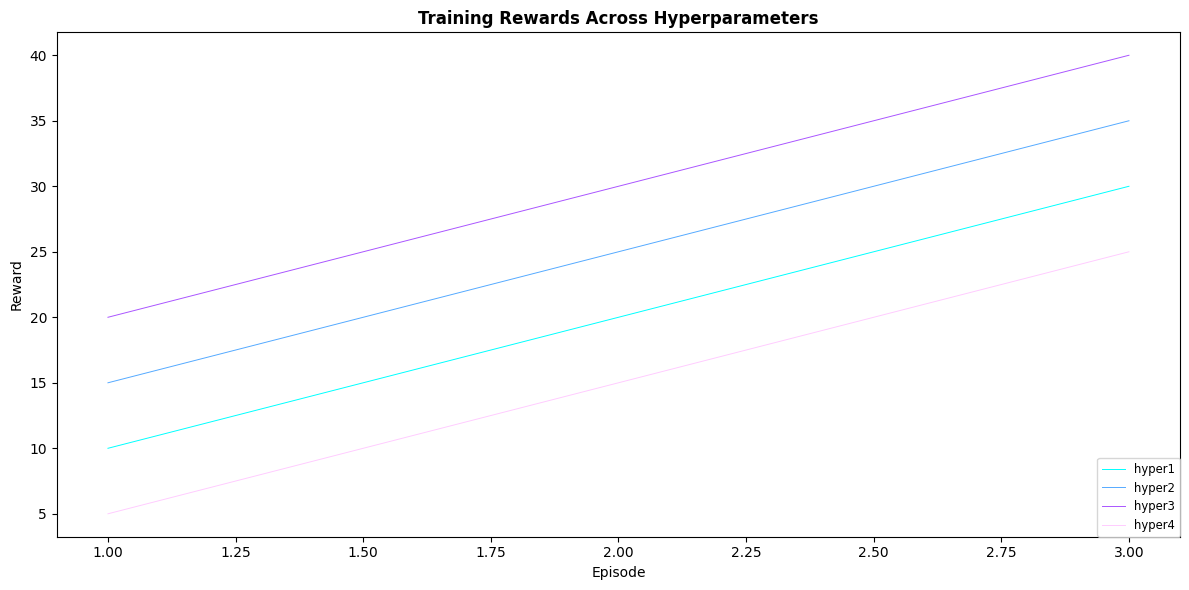

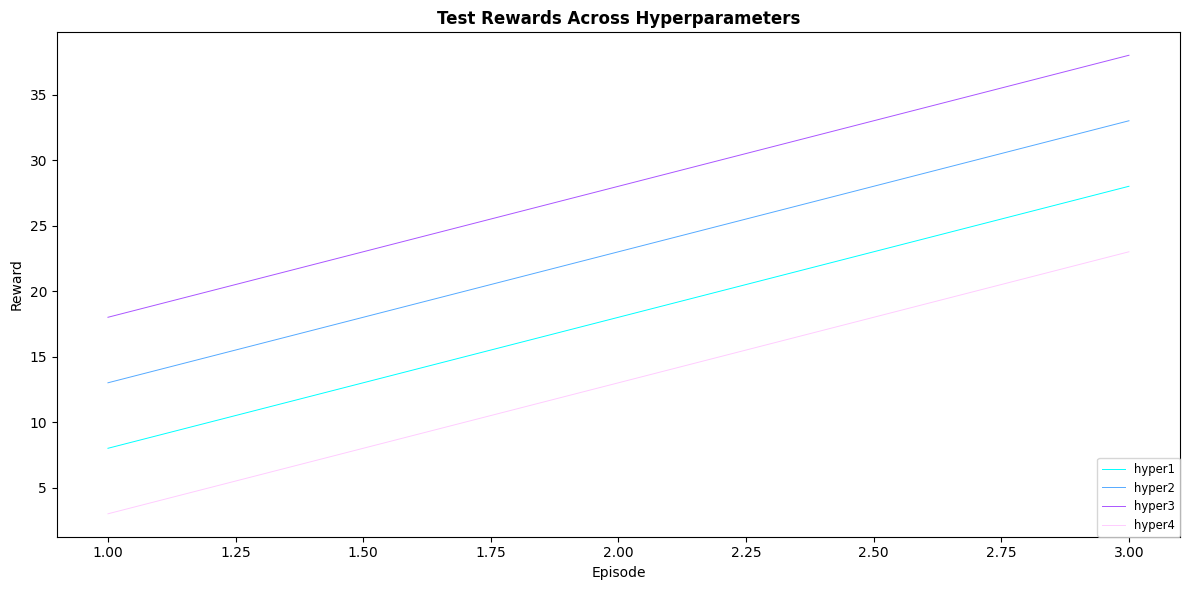

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Function to plot the reward data with the cividis colormap and adjusted opacity
def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):
    # Calculate the mean reward for each hyperparameter combination
    mean_rewards = {key: np.mean(rewards) for key, rewards in rewards_dict.items()}
    
    # Identify the top 3 hyperparameter combinations based on mean reward
    top3_keys = sorted(mean_rewards, key=mean_rewards.get, reverse=True)[:3]
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get the number of hyperparameter combinations
    num_combinations = len(rewards_dict)
    
    # Create a colormap instance
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination and plot with a color from the colormap
    for idx, (key, rewards) in enumerate(rewards_dict.items()):
        color = cmap(idx)  # Get the color for this hyperparameter combination
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.2
        ax.plot(range(1, len(rewards) + 1), rewards, label=key, color=color, alpha=alpha,linewidth=0.7)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Place the legend in the bottom-right corner, remove title, and make it smaller
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0., fancybox=True, fontsize='small', markerscale=0.5)
    fig.savefig(f'img/{img_name}.png',dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

# Plot for exp_res (training rewards)
plot_rewards_with_opacity(exp_res, "Training Rewards Across Hyperparameters", "Episode", "Reward","TR_rewards.png")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res, "Test Rewards Across Hyperparameters", "Episode", "Reward","Ts_rewards.png")


In [215]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array",use_lidar=True ) ##use_lidar=True option avaliable

agent = DQN_plus_Agent(env)
agent.train()
agent.test(num_episodes=10)

/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode: 1, Total Reward: -6.899999999999999, Epsilon: 0.9990
Episode: 2, Total Reward: -8.099999999999998, Epsilon: 0.9980
Episode: 3, Total Reward: -6.899999999999999, Epsilon: 0.9970
Episode: 4, Total Reward: -6.299999999999999, Epsilon: 0.9960
Episode: 5, Total Reward: -7.499999999999998, Epsilon: 0.9950
Episode: 6, Total Reward: -5.699999999999998, Epsilon: 0.9940
Episode: 7, Total Reward: -6.299999999999999, Epsilon: 0.9930
Episode: 8, Total Reward: -6.899999999999999, Epsilon: 0.9920
Episode: 9, Total Reward: -8.099999999999998, Epsilon: 0.9910
Episode: 10, Total Reward: -4.499999999999998, Epsilon: 0.9900
Episode: 11, Total Reward: -5.699999999999998, Epsilon: 0.9891


KeyboardInterrupt: 